In [86]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward,MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

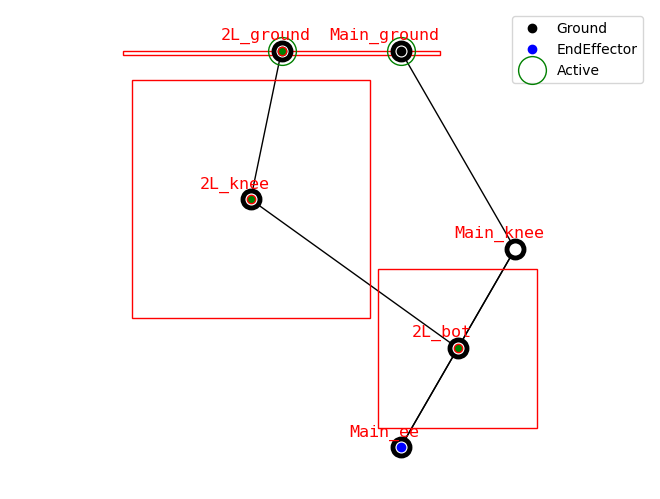

In [87]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[0]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

In [88]:
# 1) trajectories
workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.3, -0.95], 0.3, 0.6, 30, 60))
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.2, -0.9], step_height=0.2, step_width=0.4, n_points=50))
central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.9, 0.2, 0, 50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key='Manip_Jacobian')
#soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step, central_vertical])


# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step, 0)
reward_manager.add_trajectory(central_vertical, 1)
reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(min_velocity, 0, 1)
reward_manager.add_reward(heavy_lifting, 1, 1)
reward_manager.add_reward(min_force,1,1)

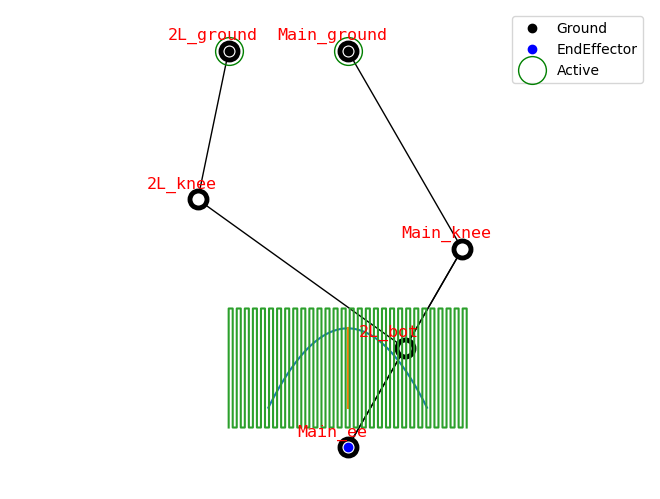

In [89]:
draw_joint_point(graph)

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [90]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

constrain_error,_ = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
print(constrain_error)

0


In [91]:
if constrain_error == 0:
    total_reward, partial_rewards = reward_manager.calculate_total(fixed_robot=fixed_robot, free_robot=free_robot, motor=actuator)

    print(total_reward)
    print(partial_rewards)

-18.08914450123727
[[0, 16.759555236279503, 0.64517343], [1, 0.014839666454656886, 0.66957617]]


In [92]:
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            soft_constrain=soft_constrain,
                                            rewards_and_trajectories=reward_manager,
                                            Actuator = actuator)

[-0.3         0.          0.14433757 -0.75       -0.37783122 -0.375     ]


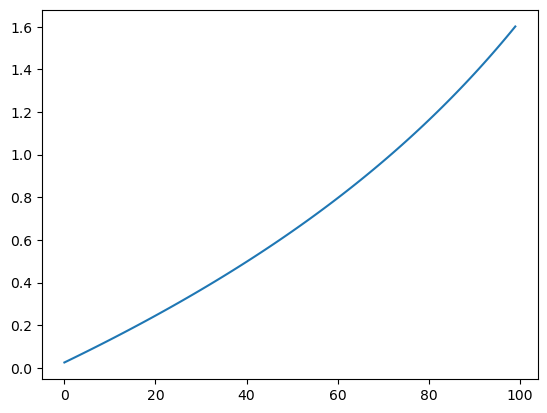

In [100]:


initial_x = problem.initial_xopt
print(initial_x)
res = np.zeros(100)
for i in range(1,101):
    additional_x = np.zeros(6)
    additional_x[0] =i*0.1*0.3*0.1 
    additional_x[4] =i*0.1*0.3*0.1
    current_x = initial_x + additional_x
    problem.mutate_JP_by_xopt(current_x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    #draw_joint_point(problem.graph)

    trajectory = central_vertical
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res[i-1] = reward

plt.show()
plt.plot(res)
plt.show()

[-0.3         0.          0.14433757 -0.75       -0.37783122 -0.375     ]


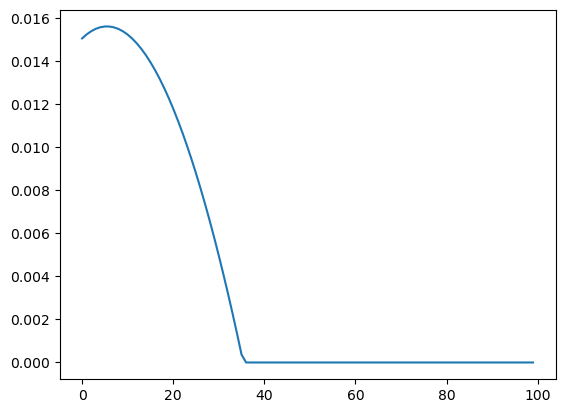

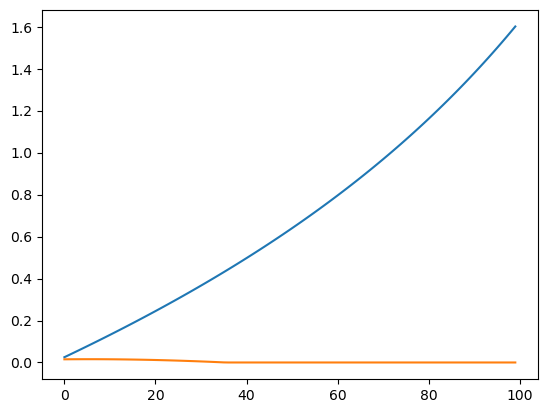

In [102]:
initial_x = problem.initial_xopt
print(initial_x)
res_1 = np.zeros(100)
for i in range(1,101):
    additional_x = np.zeros(6)
    additional_x[0] =i*0.1*0.3*0.1 
    #additional_x[4] =i*0.1*0.3*0.1
    current_x = initial_x + additional_x
    problem.mutate_JP_by_xopt(current_x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    #draw_joint_point(problem.graph)

    trajectory = central_vertical
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
    res_1[i-1] = reward

plt.plot(res_1)
plt.show()
plt.plot(res)
plt.plot(res_1)
plt.show()

In [94]:
initial_x
additional_x = np.zeros(6)
additional_x[0] = 0.03 
additional_x
initial_x+additional_x


array([-0.27      ,  0.        ,  0.14433757, -0.75      , -0.37783122,
       -0.375     ])

In [95]:
initial_x = problem.convert_joints2x_opt()[0]
initial_x

array([-0.24      ,  0.        ,  0.14433757, -0.75      , -0.37783122,
       -0.375     ])